In [35]:
import pandas as pd
import pandahouse
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, poisson
import matplotlib.pyplot as plt


## Задание 1. A/A test

In [32]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230620'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-05-24' and toDate(time) <= '2023-05-30' and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


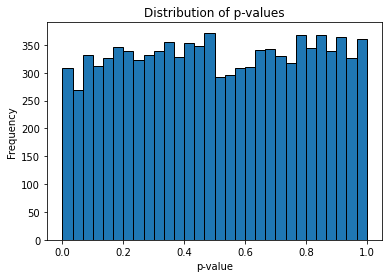

Percentage of p-values <= 0.05: 4.42%


In [2]:
# Создание списка для хранения p-values
p_values = []

# Проведение симуляции 10000 А/А-тестов
num_simulations = 10000
sample_size = 500

for _ in range(num_simulations):
    # Формирование подвыборок без повторений из 2 и 3 экспериментальной группы
    group2_sample = df[df['exp_group'] == 2].sample(sample_size, replace=False)
    group3_sample = df[df['exp_group'] == 3].sample(sample_size, replace=False)

    # Выполнение t-теста для сравнения подвыборок
    _, p_value = ttest_ind(group2_sample['ctr'], group3_sample['ctr'])
    p_values.append(p_value)

# Построение гистограммы распределения p-values

plt.hist(p_values, bins=30, edgecolor='black')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values')
plt.show()

# Вычисление процента p-values <= 0.05
p_values = np.array(p_values)
percentage = np.mean(p_values <= 0.05) * 100
print(f'Percentage of p-values <= 0.05: {percentage}%')


Проведенная симуляция А/А-теста показала, что процент p-values меньше или равных 0.05 составляет 4.6%. Это означает, что только в приблизительно 4.6% случаев мы бы получили статистически значимые различия между группами (2 и 3 экспериментальной группой). Похоже, что наша система сплитования в целом работает корректно.

## Задание 2. Сглаженный CTR и А/B test

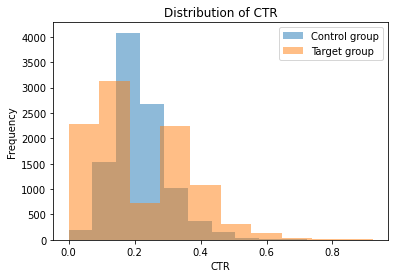

In [85]:

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230620'
}

q2 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-05-31' and toDate(time) <= '2023-06-06'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q2, connection=connection)
group1 = df[df['exp_group'] == 1].copy()
group2 = df[df['exp_group'] == 2].copy()

plt.hist(group1['ctr'], alpha=0.5, label='Control group')
plt.hist(group2['ctr'], alpha=0.5, label='Target group')
plt.xlabel('CTR')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of CTR')
plt.show()


Хочется сгладить CTR, чтобы нивелировать выбросы, а потом провести t-test

In [86]:
# Рассчитаем групповые CTR:
global_ctr_1 = group1.likes.sum()/group1.views.sum()
global_ctr_2 = group2.likes.sum()/group2.views.sum()

In [87]:
# Посчитаем сглаженный CTR:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

group1['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [88]:
# Теперь можно перейти к t-test:
from scipy import stats

stats.ttest_ind(group1.smoothed_ctr,
                group2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.022376981555855876)

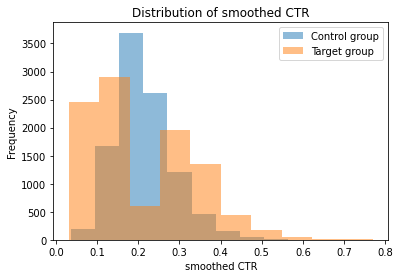

In [89]:
# Посмотрим на распределения сглаженного CTR:
plt.hist(group1['smoothed_ctr'], alpha=0.5, label='Control group')
plt.hist(group2['smoothed_ctr'], alpha=0.5, label='Target group')
plt.xlabel('smoothed CTR')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of smoothed CTR')
plt.show()

T-test говорит, что группы статистически отличаются, но при взгляде на график это не кажется таким очевидным. Чтобы лучше оценить распределения этих двух групп, можно провести Пуассоновский бутстреп (который побыстрее обычного).

<Axes: ylabel='Count'>

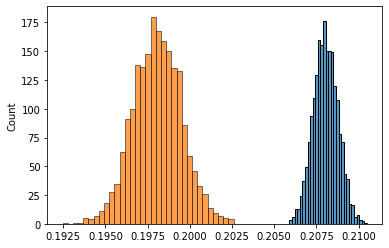

In [91]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Теперь сомнений не осталось - алгоритм работает, можно выкатывать на всех пользователей.

## Задание 3. Линеаризированные лайки

Посчитаем линеаризованные лайки в группах 0 и 3. На всякий случай повторим что есть что:
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"


In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230620'
}

q3 = """
WITH CTR_control as
    (SELECT sum(action = 'like') / sum(action = 'view') as CTR_control
    FROM {db}.feed_actions
    WHERE exp_group = 0)
    
SELECT 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    sum(action = 'like') / sum(action = 'view') as ctr,
    sum(action = 'like') - (SELECT CTR_control FROM CTR_control) * sum(action = 'view') as linerized_likes
FROM {db}.feed_actions
WHERE 
    toDate(time) >= '2023-05-31' AND 
    toDate(time) <= '2023-06-06' AND 
    exp_group IN (0, 3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q3, connection=connection)
group0 = df[df['exp_group'] == 0].copy()
group3 = df[df['exp_group'] == 3].copy()

In [4]:
from scipy import stats

stats.ttest_ind(group0.linerized_likes,
                group3.linerized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.209006203907894, pvalue=6.011422065955615e-52)

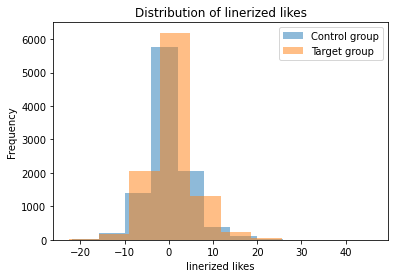

In [5]:
# взглянем на график:
plt.hist(group0['linerized_likes'], alpha=0.5, label='Control group')
plt.hist(group3['linerized_likes'], alpha=0.5, label='Target group')
plt.xlabel('linerized likes')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of linerized likes')
plt.show()

Похоже что новый алгоритм работает, t-test также показал стат. значимое различие. 
Теперь перейдем к проверки другого алгоритма:
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

In [30]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230620'
}

q3 = """
WITH CTR_control as
    (SELECT sum(action = 'like') / sum(action = 'view') as CTR_control
    FROM {db}.feed_actions
    WHERE exp_group = 1)
    
SELECT 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    sum(action = 'like') / sum(action = 'view') as ctr,
    sum(action = 'like') - (SELECT CTR_control FROM CTR_control) * sum(action = 'view') as linerized_likes
FROM {db}.feed_actions
WHERE 
    toDate(time) >= '2023-05-31' AND 
    toDate(time) <= '2023-06-06' AND 
    exp_group IN (1, 2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q3, connection=connection)
group1 = df[df['exp_group'] == 1].copy()
group2 = df[df['exp_group'] == 2].copy()

In [31]:
from scipy import stats

stats.ttest_ind(group1.linerized_likes,
                group2.linerized_likes,
                equal_var=False)


Ttest_indResult(statistic=6.104713391510412, pvalue=1.0555106533129094e-09)

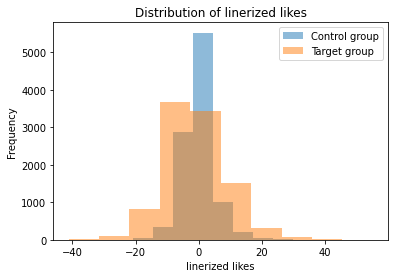

In [33]:
# взглянем на график:
plt.hist(group1['linerized_likes'], alpha=0.5, label='Control group')
plt.hist(group2['linerized_likes'], alpha=0.5, label='Target group')
plt.xlabel('linerized likes')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of linerized likes')
plt.show()

Алгоритм с рекомендациями на основе лайкнутых постов, судя по всему, работает (при уровне значимости 5%). 

In [38]:
p_value_linerized_likes = stats.ttest_ind(group1.linerized_likes,
                group2.linerized_likes,
                equal_var=False)[1]
p_value_ctr = stats.ttest_ind(group1.ctr,
                group2.ctr,
                equal_var=False)[1]
if (p_value_linerized_likes > p_value_ctr): 
    print('P-value не уменьшилось')
else:
    print('P-value уменьшилось')

P-value уменьшилось
